# Studying the 2024 April 8 Solar Eclipse with Astropy

## Goals

- Learn about the 2024 Eclipse.

- Model it with Astropy.

- Check our work against the USNO.

## References

- Demo notebook by H. Snyder for the 2017-08-21 Solar Eclipse
  - https://share.cocalc.com/share/6240aa60ea491184867f4691b042d7d108326478/Public/Eclipse.sagews?viewer=share
  - used geopy and pyephem
  - did not use astropy

- Adrian Price-Whelan, Visualizing the 2017 eclipse with Astropy, 2017-08-20
  - http://adrian.pw/blog/astropy-eclipse/

- US Naval Observatory 2024 April 08 Eclipse information / Calculate local circumstances
  - https://aa.usno.navy.mil/data/docs/Eclipse2024.php

## Extra Sources

- Juna Kollmeier, TED Talk
  - The most detailed map of galaxies, black holes and stars ever made
  - https://www.ted.com/talks/juna_kollmeier_the_most_detailed_map_of_galaxies_black_holes_and_stars_ever_made

- Astropy 3.2 (2019-06-10)
  - What's new:
  - http://docs.astropy.org/en/stable/whatsnew/3.2.html

<img src="ats_0212024.gif" width="30%">

Image credit: [US Naval Observatory](https://aa.usno.navy.mil/data/docs/Eclipse2024.php).


## Step 1. Get basic info from USNO.

### Palatine (partial eclipse)

<img src="usno-2024.png" width="70%">

### Carbondale (total eclipse)

<img src="usno-2024-carb.png" width="70%">


## Step 2. Follow the steps of Adrian Price-Whelan's 2017 notebook.

This will give us animations and the setup for basic stats.

Add geopy so it knows about the Palatine Library.

In [1]:
from datetime import datetime

import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
import numpy as np
import pytz
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, MinuteLocator, DateFormatter
import matplotlib.animation as animation
import matplotlib as mpl

import math
from tzwhere import tzwhere
import ipywidgets as widgets

In [2]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [3]:
aw = widgets.Dropdown(
    options=['Palatine Public Library, Palatine, IL',
            'Carbondale Public Library, Carbondale, IL'],
    value='Palatine Public Library, Palatine, IL',
    description="Location:",
    disabled=False,
)
display(aw)

Dropdown(description='Location:', options=('Palatine Public Library, Palatine, IL', 'Carbondale Public Library…

In [4]:
address = aw.value
print(f'Observer location: {address}')

Observer location: Carbondale Public Library, Carbondale, IL



### Choose a range of 1024 equally-spaced times that span the eclipse

17:00 UTC to 21:00 UTC

In [5]:
# geopy gets street address and county for the library as well as long/lat. Cool.
import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="chi-eclipse")
location = geolocator.geocode(address)
print(location.address)
print(f'lon: {location.longitude}, lat: {location.latitude}')

Carbondale Public Library, 405, West Main Street, Carbondale, Jackson County, Illinois, 62901, USA
lon: -89.2206215599511, lat: 37.7265691


In [6]:
# infer timezone from lat/long
tzw = tzwhere.tzwhere()
tzn = tzw.tzNameAt(location.latitude, location.longitude)
tzn

'America/Chicago'

In [7]:
mpl.rcParams['timezone'] = tzn
tz = pytz.timezone(mpl.rcParams['timezone'])
times = (Time(datetime(2024, 4, 8, 17, 0, 0).astimezone(pytz.UTC))
         + np.linspace(0, 4, 1024) * u.hour)
dt = times.to_datetime(tz)

In [8]:
location.altitude

0.0

In [9]:
loc = coord.EarthLocation(lon=location.longitude*u.deg, lat=location.latitude*u.deg, height=0*u.m)

In [10]:
# use the astropy ephemeris to get coordinates of moon and sun
# for the range of times
moon = coord.get_moon(times)
sun = coord.get_sun(times)

In [11]:
# adjust for our observation point
alt_az = coord.AltAz(obstime=times, location=loc)
moon_aa = moon.transform_to(alt_az)
sun_aa = sun.transform_to(alt_az)

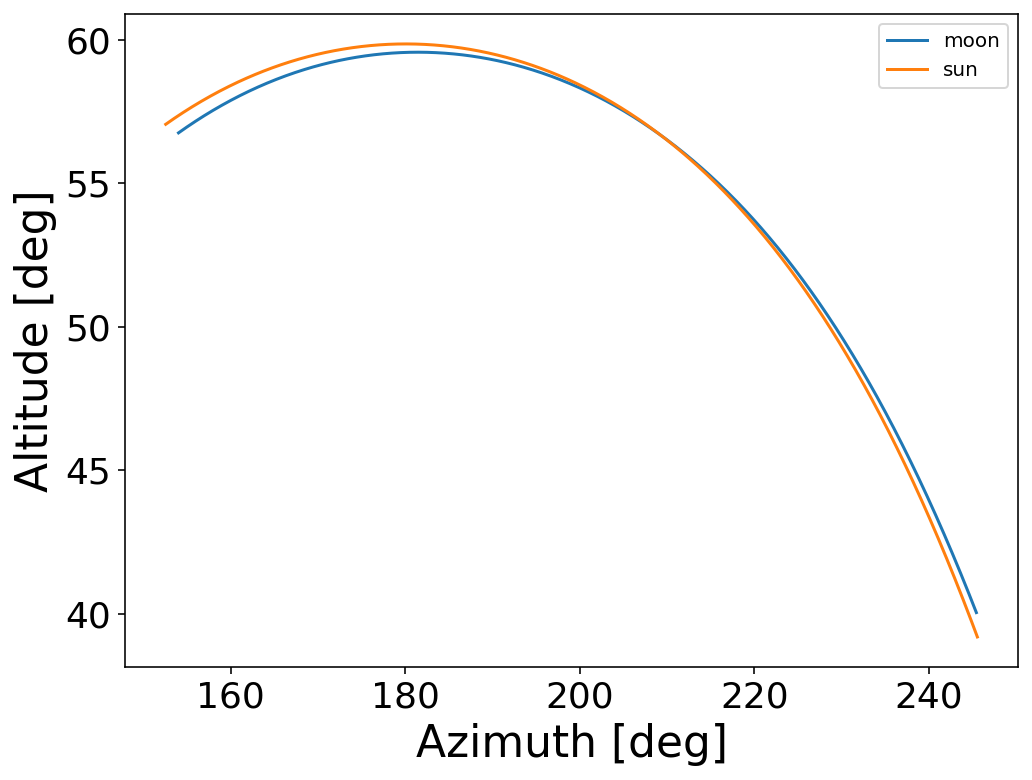

In [12]:
# plot the course through the sky of moon and sun
# they are very similar!
plt.plot(moon_aa.az, moon_aa.alt, marker='None', linestyle='-', label='moon')
plt.plot(sun_aa.az, sun_aa.alt, marker='None', linestyle='-', label='sun')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Altitude [deg]')
plt.legend();

In [13]:
# the key to eclipse calculation is the separation of the two bodies in the sky
sun_moon_sep = moon_aa.separation(sun_aa)

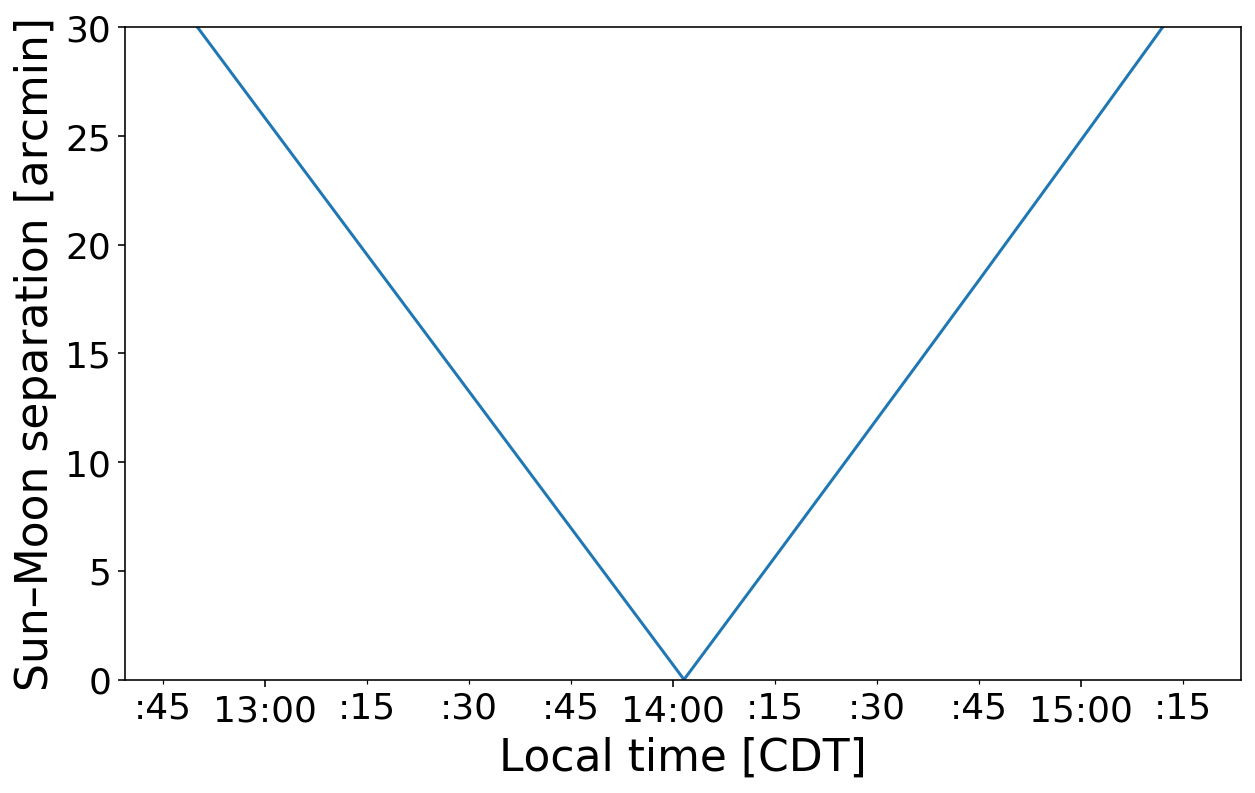

In [14]:
# plot the angular separation as a function of time
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(dt, sun_moon_sep.to(u.arcmin), marker='None')

offset = 350
ax.xaxis_date(tz=tz)
ax.set_xlim(dt[sun_moon_sep.argmin() - offset],
            dt[sun_moon_sep.argmin() + offset])

ax.xaxis.set_major_locator(HourLocator())
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(MinuteLocator(byminute=np.arange(15, 60, 15)))
ax.xaxis.set_minor_formatter(DateFormatter(':%M'))

ax.set_ylim(0, 30)

ax.set_xlabel('Local time [{0:%Z}]'.format(dt[0]))
ax.set_ylabel('Sun–Moon separation [arcmin]');

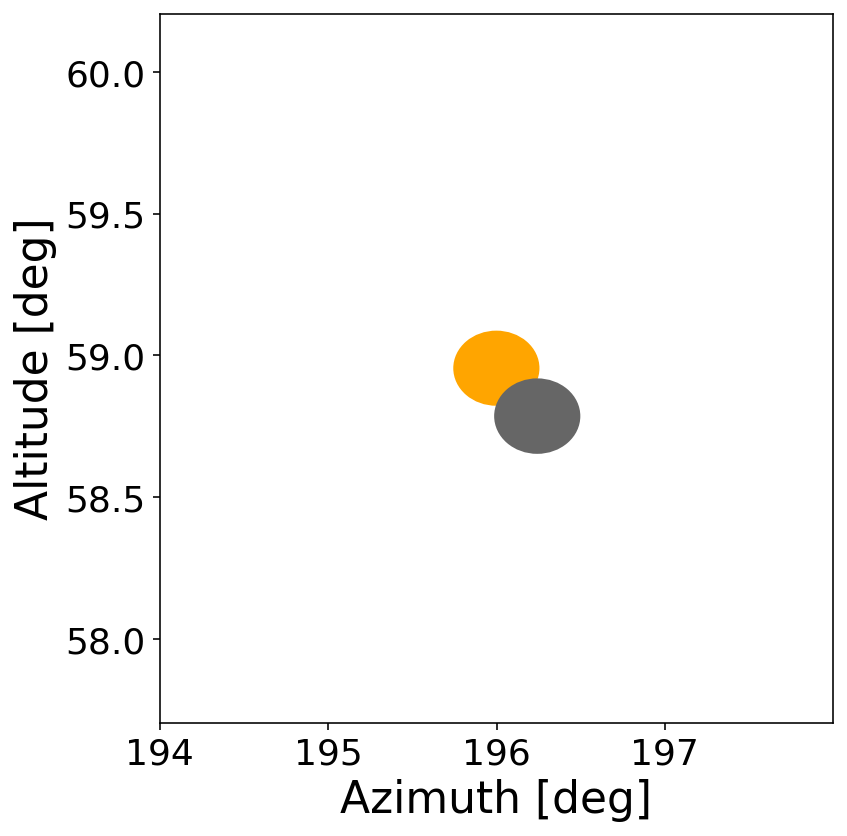

In [15]:
## Animate the eclipse for the time range
# centered on the sun
# approximate shapes of sun and moon by 1/2-degree ellipses

i0 = sun_moon_sep.argmin() - 128
i1 = sun_moon_sep.argmin() + 128

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

x = np.arange(0, 2*np.pi, 0.01)

moon_pa = mpl.patches.Ellipse((0,0), width=0.5, height=0.5,
                              color='#666666', zorder=10)
sun_pa = mpl.patches.Ellipse((0,0), width=0.5, height=0.5,
                             color='orange', zorder=1)
ax.add_patch(moon_pa)
ax.add_patch(sun_pa)

ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Altitude [deg]')

#ax.set_aspect(1.6)

fig.tight_layout()

def animate(i):
    moon_pa.center = [moon_aa.az[i].degree, moon_aa.alt[i].degree]
    sun_pa.center = [sun_aa.az[i].degree, sun_aa.alt[i].degree]

    moon_pa.height = 0.5 * np.cos(moon_aa.alt[i])
    sun_pa.height = 0.5 * np.cos(sun_aa.alt[i])

    az_lim = (sun_aa.az[i].to(u.degree).value - 2,
              sun_aa.az[i].to(u.degree).value + 2)
    #alt_lim = (sun_aa.alt[i].to(u.degree).value - 2,
    #           sun_aa.alt[i].to(u.degree).value + 2)
    alt_lim = (sun_aa.alt[i].to(u.degree).value - 1.25,
               sun_aa.alt[i].to(u.degree).value + 1.25)

    ax.set_xlim(az_lim)
    ax.set_ylim(alt_lim)

    return moon_pa, sun_pa

def init():
    return animate(i0)

ani = animation.FuncAnimation(fig, animate, np.arange(i0, i1),
                              init_func=init, interval=25, blit=True, repeat=False)

In [16]:
HTML(ani.to_html5_video())

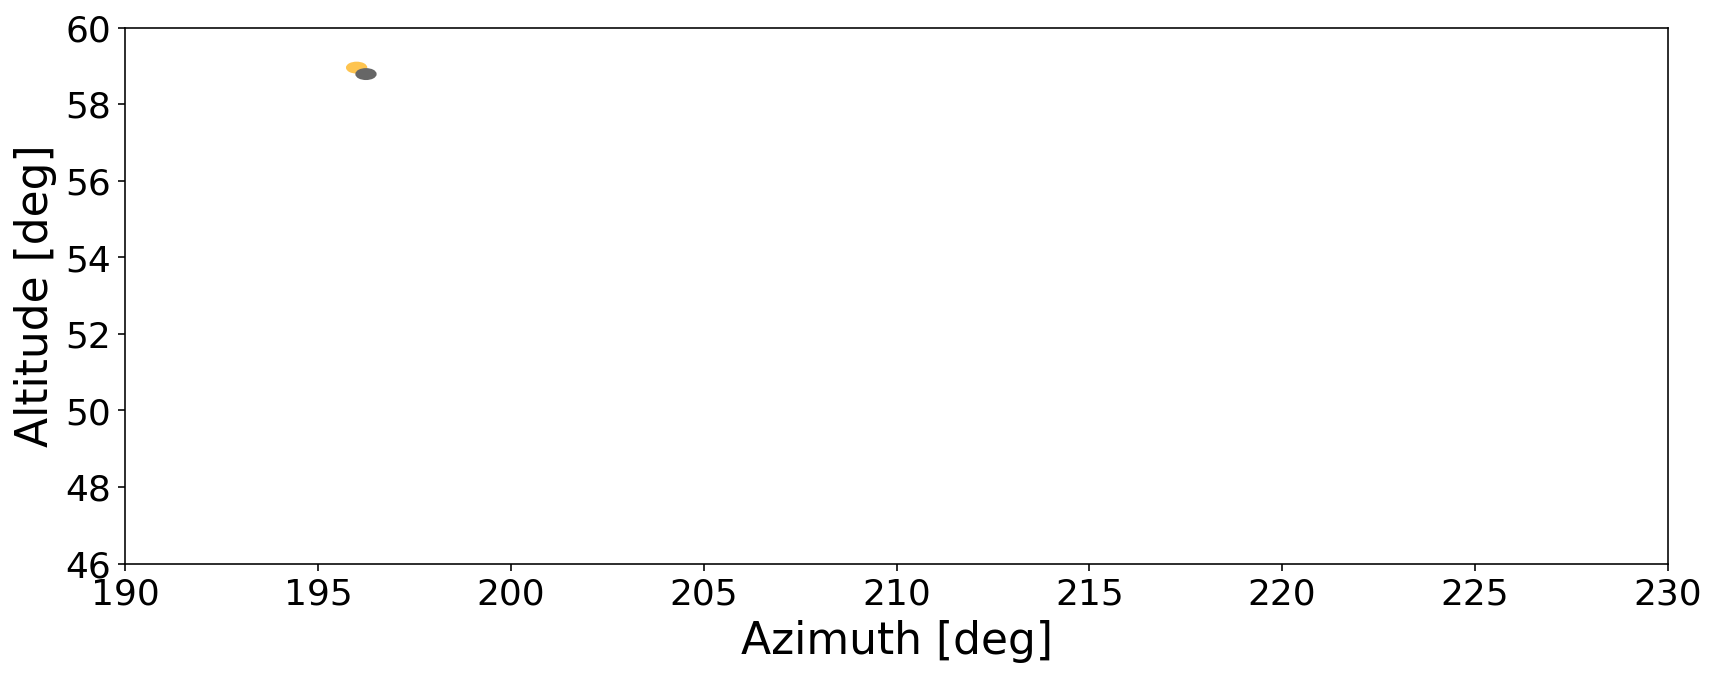

In [22]:
# Animation with frame fixed in the sky

i0 = sun_moon_sep.argmin() - 128
i1 = sun_moon_sep.argmin() + 128

fig2, ax = plt.subplots(1, 1, figsize=(12, 4.8))

x = np.arange(0, 2*np.pi, 0.01)

moon_pa = mpl.patches.Ellipse((0,0), width=0.5, height=0.5,
                              color='#666666', zorder=10)
sun_pa = mpl.patches.Ellipse((0,0), width=0.5, height=0.5,
                             color='#fec44f', zorder=1)
ax.add_patch(moon_pa)
ax.add_patch(sun_pa)

ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Altitude [deg]')

#ax.set_xlim(195, 225)
#ax.set_ylim(35, 65)
ax.set_xlim(190, 230)
ax.set_ylim(46, 60)

fig2.tight_layout()

def animate2(i):
    moon_pa.center = [moon_aa.az[i].degree, moon_aa.alt[i].degree]
    sun_pa.center = [sun_aa.az[i].degree, sun_aa.alt[i].degree]

    moon_pa.height = 0.5 * np.cos(moon_aa.alt[i])
    sun_pa.height = 0.5 * np.cos(sun_aa.alt[i])

    return moon_pa, sun_pa

def init2():
    return animate2(i0)

ani2 = animation.FuncAnimation(fig2, animate2, np.arange(i0, i1),
                               init_func=init2, interval=25, blit=True)

ani2

In [23]:
HTML(ani2.to_html5_video())


## Step 3. Summary stats

In [19]:
# maximum obscuration time

max_obsc = dt[sun_moon_sep.argmin()]
print(max_obsc.strftime("%Y-%m-%d %H:%M:%S"))

2024-04-08 14:01:31



# look up subtended arcs of sun and moon

- sun: The sun subtends an angle of approximately 0.52° (31 arc-minutes)
- moon: The moon subtends an angle of approximately 0.54° (32 arc-minutes)

https://www.mathopenref.com/subtend.html

In [20]:
# maximum obscuration percent

# area of the lune
# https://rechneronline.de/pi/lune.php

r_sun = 31 * 60 / 2
r_moon = 32 * 60 / 2
s = sun_moon_sep.min().arcsec
if s < abs(r_sun - r_moon):
    print('total eclipse')
    percent_eclipse = 100.0
else:
    print('not total eclipse')
    ld = lunedelta=0.25*math.sqrt((r_sun+r_moon+s)*(r_moon+s-r_sun)*(s+r_sun-r_moon)*(r_sun+r_moon-s))
    lune_area=2*ld + r_sun*r_sun*(math.acos(((r_moon*r_moon)-(r_sun*r_sun)-(s*s))/(2*r_sun*s))) - r_moon*r_moon*(math.acos(((r_moon*r_moon)+(s*s)-(r_sun*r_sun))/(2*r_moon*s)))

    # Calculate percentage of sun's disc eclipsed using lune area and sun size
    percent_eclipse=(1-(lune_area/(math.pi*r_sun*r_sun)))*100
print(percent_eclipse)

total eclipse
100.0


In [21]:
# first and last contact times
# look for angular separation around 31.5 arcmin
for ix in range(len(dt)):
    aax = sun_moon_sep[ix].arcmin
    if abs(aax - 31.5) < 0.07:
        dtx = dt[ix]
        print(aax,dtx.strftime("%Y-%m-%d %H:%M:%S"))

31.50937446332045 2024-04-08 12:46:27
31.466209730789473 2024-04-08 15:15:25
31.568332046616916 2024-04-08 15:15:39


## Results for Palatine Public Library

US Naval Observatory posted times have been converted from UTC to US/Central.

Source: [Solar Eclipse Computer - Solar Eclipse of 2024 April 08 - Palatine, IL](https://aa.usno.navy.mil/solareclipse?eclipse=12024&state=IL&place=palatine&height=0)


| value | USNO | calculations in this worksheet |
|-----|-----|-----|
| First contact time |12:51:13.9|12:54:39|
| Maximum obscuration time |14:07:14.4|14:07:37|
| Maximum obscuration |92.4%|90.4%|
| Last contact time |15:21:29.0|15:18:56|

## Results for Carbondale Public Library

US Naval Observatory posted times have been converted from UTC to US/Central.

Source: [Solar Eclipse Computer - Solar Eclipse of 2024 April 08 - Carbondale, IL](https://aa.usno.navy.mil/solareclipse?eclipse=12024&state=IL&place=carbondale&height=0)


| value | USNO | calculations in this worksheet |
|-----|-----|-----|
| First contact time |12:42:55|12:46:27|
| Maximum obscuration time |14:01:14|14:01:31|
| Maximum obscuration |100%|100%|
| Last contact time |15:18:04.0|15:15:32|